In [ ]:
import sys
!conda install -c conda --yes --prefix {sys.prefix} tensorflow

In [1]:
from glob import glob
import datetime as dt
import pandas as pd
import geopandas as gpd
from datetime import datetime
import keras

# Initialize Data

In [154]:
# Files with data
paths = glob('C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/sentinel_ismn_data/*',)
paths.sort()

# Create Station id linked with filepath
ids = [x.split('\\')[-1].split('_')[0] for x in paths]
files = dict(zip(ids,paths))

# Load all files into one Dataframe
gdf = gpd.tools.util.pd.concat(map(gpd.read_file, paths), ignore_index=True)

# Preprocessing

In [155]:
# Set type of date column to datetime object
gdf.date = gdf.date.astype('datetime64[ns]')

# Convert int to timedelta in days
s2_timedelta = [dt.timedelta(days=x) for x in gdf.s2_distance]
gdf.s2_distance = s2_timedelta

#Remove uneseccary columns
gdf.drop(labels = ['CloudMask'], axis = 1, inplace = True)

# Clean Nan Values within subset columns (major variables to inspect)
gdf.dropna(how='any', subset=['soil_moisture', 'VV'], inplace=True)

# Drop lower and upper 1% of data to eliminate outliers
gdf = gdf[gdf.soil_moisture.gt(gdf.soil_moisture.quantile(0.01)) & gdf.soil_moisture.lt(gdf.soil_moisture.quantile(0.99))]
gdf = gdf[gdf.VV.gt(gdf.VV.quantile(0.01)) & gdf.VV.lt(gdf.VV.quantile(0.99))]
#gdf = gdf[gdf.NDVI.gt(gdf.NDVI.quantile(0.01)) & gdf.NDVI.lt(gdf.NDVI.quantile(0.99))]

# Remove rows where ndvi is older than 30days
gdf = gdf[gdf.s2_distance.gt(dt.timedelta(days=-7)) & gdf.s2_distance.lt(dt.timedelta(days=7))]

# Select only sm and vv meassurements where soil is not in frozen state


In [51]:
len(gdf)

23917

## Scale, Transform dataset according to regression

In [61]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

## One hot encoding

In [159]:
# Drop categorical data 
orbit = gdf.pop('orbit')
platform = gdf.pop('platform')
#soil_moisture_flag = gdf.pop('soil_moisture_flag')

In [162]:
gdf['ASCENDING'] = (orbit == 'ASCENDING')*1
gdf['DESCENDING'] = (orbit == 'DESCENDING')*1

gdf['Sentinel_A'] = (platform == 'A')*1
gdf['Sentinel_B'] = (platform == 'B')*1

#gdf['soil_moisture_flag'] = (orbit == 'A')*1
#gdf['soil_moisture_flag'] = (orbit == 'B')*1

In [164]:
gdf.columns

Index(['ismn_id', 'date', 'VV', 'VH', 'angle', 'img_id', 'Aerosols', 'Blue',
       'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4', 'NIR',
       'WaterVapor', 'Cirrus', 'SWIR1', 'SWIR2', 'NDVI', 'date_y',
       's2_distance', 'soil_moisture', 'soil_moisture_flag',
       'soil_moisture_orig_flag', 'geometry', 'ASCENDING', 'DESCENDING',
       'Sentinel_A', 'Sentinel_B'],
      dtype='object')

## Split data into train and test

In [88]:
df = pd.DataFrame(gdf[['VV', 'soil_moisture']]).reset_index(drop=True)
train_df = df.sample(frac = 0.8, random_state=0)
test_df = df.drop(train_df.index)

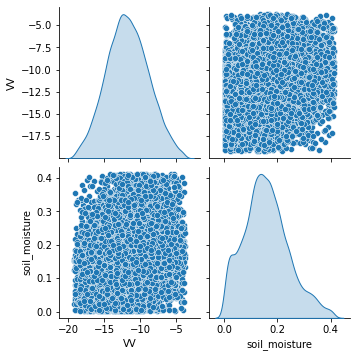

In [56]:
sns.pairplot(train_df, diag_kind = 'kde')

In [89]:
train_stats = train_df.describe()
train_stats.pop('soil_moisture')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
VV,19134.0,-11.760338,2.902429,-19.189174,-13.80853,-11.835246,-9.77512,-3.736842


## Split features from labels

In [90]:
train_labels = train_df.pop('soil_moisture')
test_labels = test_df.pop('soil_moisture')

## Normalize data

In [62]:
csc = MinMaxScaler()
lsc = LabelBinarizer()

In [92]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [95]:
n_train_df = norm(train_df)
n_test_df = norm(test_df)

# The model

## Architecture

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.nn import relu
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

In [96]:
def build_model():
    model = Sequential([
        layers.Dense(64, activation=relu, input_shape=[len(n_train_df.keys())]), # densly (fully connected) hidden layer
        layers.Dense(64, activation=relu), # denly hidden layer
        layers.Dense(1) #output layer
    ])
    
    optimizer = RMSprop(0.001)
    
    model.compile(
        loss = 'mse', # mean sqared error
        optimizer = optimizer,
        metrics = ['mae', 'mse']) 
    
    return model

In [97]:
model = build_model()

## Inspect Model

In [99]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_41 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [139]:
# Callbacks
class Calls(Callback):
    #Print dot every epoch while training
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
    
# stop the training when there is no improvement in the loss for three consecutive epochs.
stop_improving = EarlyStopping(monitor='val_loss', patience=10)
        



In [140]:
EPOCHS = 1000

history = model.fit(
    x = n_train_df,
    y = train_labels,
    epochs = EPOCHS,
    validation_split = 0.2, 
    verbose = 0,
    callbacks = [Calls(), stop_improving])


.............................

In [141]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,0.006676,0.065318,0.006676,0.006634,0.065050,0.006634,0
1,0.006678,0.065333,0.006678,0.006646,0.064945,0.006646,1
2,0.006681,0.065306,0.006681,0.006635,0.065005,0.006635,2
3,0.006677,0.065338,0.006677,0.006634,0.065179,0.006634,3
4,0.006680,0.065352,0.006680,0.006657,0.065445,0.006657,4
5,0.006679,0.065317,0.006679,0.006636,0.065070,0.006636,5
6,0.006681,0.065382,0.006681,0.006634,0.065006,0.006634,6
7,0.006681,0.065362,0.006681,0.006655,0.065453,0.006655,7
8,0.006677,0.065359,0.006677,0.006635,0.065071,0.006635,8
9,0.006678,0.065340,0.006678,0.006632,0.065055,0.006632,9


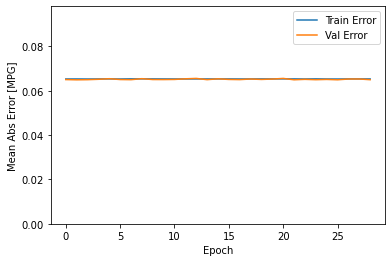

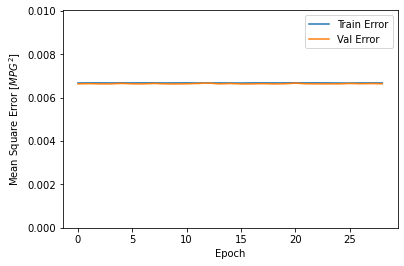

In [142]:
import matplotlib.pyplot as plt

def plot_history(hitsory):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
            label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label = 'Val Error')
    plt.legend()
    plt.ylim([0,hist['mae'].max() + hist['mae'].max() * 0.5])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
            label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')
    plt.legend()
    plt.ylim([0,hist['mse'].max() + hist['mse'].max() * 0.5])

plot_history(history)

In [143]:
loss, mae, mse = model.evaluate(n_test_df, test_labels, verbose = 0)
print("Testing set Mean Abs Error: {:5.2f} m^3/m^3".format(mae))

Testing set Mean Abs Error:  0.06 m^3/m^3


## Make Predictions

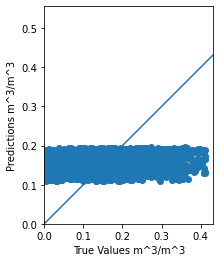

In [147]:
test_predictions = model.predict(n_test_ds).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values m^3/m^3')
plt.ylabel('Predictions m^3/m^3')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100], [-100,100])

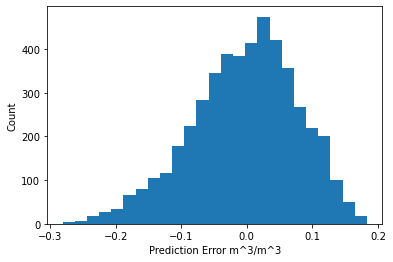

In [148]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error m^3/m^3')
_ = plt.ylabel('Count')

## First Try: 2 Feature [sm, vv] / No Seperation between different Paramters 

In [7]:
X = gdf['VV'].reset_index(drop=True).iloc[0:100]
Y = gdf['soil_moisture'].reset_index(drop=True).iloc[0:100]

In [11]:
# Evaluate Model
estimator = KerasRegressor(
    build_fn = baseline_model,
    epochs = 100, 
    batch_size = 5,
    verbose = 0)
kfold = KFold(n_splits = 10) #10-fold cross validation to evaluate the model
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))
print(f"Baseline: {results.mean()}%.2f ({results.std()}%.2f) MSE")

Baseline: -0.01 (0.00) MSE
Baseline: -0.00545312357135117%.2f (0.004011123769375037%.2f) MSE


In [ ]:
features = ['VV', 'soil_moisture']
df = gdf[features].reset_index(drop=True)
sc_data = csc.fit_transform(df)
X_train, X_test, y_train, y_test = train_test_split(sc_data[:,0],sc_data[:,1], test_size=0.25, random_state = 42, shuffle=False, stratify=None)

In [ ]:
model = models.create_mlp(X_train, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss='mean_absolute_percentage_error', optimizer=opt)

# Train the model
model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_test, y_test),
    epoches = 200,
    batch_size = 8
    )

In [ ]:
def prep_scaling(df, modus, features):
    """
    Arguments: modus ['MinMax', 'LabelBinarizer']
    """
    # Import modlues
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.preprocessing import MinMaxScaler
    
    # Initialize Scaler ?What is with negative numbers?
    if modus == 'MinMax':
        cs = MinMaxScaler()
    elif modus == 'LabelBinarizer':
        cs = LabelBinarizer()
    
    return cs.fit_transform(df[columns])

In [ ]:
data_1 = prep_scaling(
    df = gdf,
    modus = 'MinMax',
    columns = ['VV', 'soil_moisture'],
    )
data_1 sklearn.model_selection.train_test_split

In [ ]:
df_1 = gdf[['soil_moisture', 'VV']].reset_index(drop=True) #2 Feature Selection


x = gdf.VV.reset_index(drop=True) # Sentinel 1 GRD VV Backscatter Coefficient
y = gdf.soil_moisture.reset_index(drop=True) # Soil Moisture



In [ ]:
data = gpd.read_file(ismn_path + '\ismn_ts_vv_sm_01.json')
data['date'] = pd.to_datetime(data.date)

In [ ]:
ms1_x, ms1_y, ms2_x, ms2_y, as1_x, as1_y, as2_x, as2_y = list(), list(),list(),list(),list(),list(),list(),list()

for station in data.station.unique():
    for year in data.date.dt.year.unique():
        time_series = data[(data['station'] == station ) & (data['date'].dt.year == year) & (data['date'].dt.month.isin([3,4,5,6,7,8,9]))]
        #Sentinel A Ascending 
        ms1_x.append(time_series[(time_series['sentinel'] == 'A') & (time_series['orbit_direction'] == 'ASCENDING')]['VV'])
        ms1_y.append(time_series[(time_series['sentinel'] == 'A') & (time_series['orbit_direction'] == 'ASCENDING')][['angle', 'soil_moisture']])
        # Sentinel B Ascending
        ms2_x.append(time_series[(time_series['sentinel'] == 'B') & (time_series['orbit_direction'] == 'ASCENDING')]['VV'])
        ms2_y.append(time_series[(time_series['sentinel'] == 'B') & (time_series['orbit_direction'] == 'ASCENDING')][['angle', 'soil_moisture']])
        # Sentinel A Descending
        as1_x.append(time_series[(time_series['sentinel'] == 'A') & (time_series['orbit_direction'] == 'DESCENDING')]['VV'])
        as1_y.append(time_series[(time_series['sentinel'] == 'A') & (time_series['orbit_direction'] == 'DESCENDING')][['angle', 'soil_moisture']])
        # Sentinel B Descending
        as2_x.append(time_series[(time_series['sentinel'] == 'B') & (time_series['orbit_direction'] == 'DESCENDING')]['VV'])
        as2_y.append(time_series[(time_series['sentinel'] == 'B') & (time_series['orbit_direction'] == 'DESCENDING')][['angle', 'soil_moisture']])


## Download Sentinel-1 Metadata

In [ ]:
def get_s1_metadata(filename):
    from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
    # connect to the API
    api = SentinelAPI('till90', '201184Till', 'https://scihub.copernicus.eu/dhus')
    # Query Metadata by filename
    products = api.query(filename = f'{filename}*')
    return api.to_dataframe(products)

In [ ]:
get_s1_metadata('S1A_IW_GRDH_1SDV_20150104T051921_20150104T051946_004017_004D70_3611').orbitdirection.values[0]

## Data to train the CNN

### ismn in-situ soil moisture

In [ ]:
#path to single json files per station
ismn_path = r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\ground_trouth\ismn_archieve\time_series'
files = glob(ismn_path + '\*')

In [ ]:
files = files[:-1]

In [ ]:
#load time series in pandas
ts_ismn_sm = [pd.read_json(x) for x in files]
# Get coords from filename
coords = [x.split('\\')[-1].split('_')[1:3] for x in files]
# Create GeoDataFrame for every time series with geometry from filename 
ts_ismn_sm_gdf = [gpd.GeoDataFrame(data = ts_ismn_sm[x], geometry=gpd.points_from_xy(x = np.repeat(coords[x][1], len(ts_ismn_sm[x])), y = np.repeat(coords[x][0], len(ts_ismn_sm[x])))) for x in range(0,len(files))]
# Concat all gdf to one geodataframe
ts_ismn = gpd.tools.util.pd.concat(ts_ismn_sm_gdf)

In [ ]:
coords

In [ ]:
# Extract regular sampled; 1 values for 1 day at the same time s1 meassure backscatter coeffienct


### gee sentinel 1 data

In [ ]:
#path to single json files per station
gee_fc_path = r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\ground_trouth\ismn_fc_gee_VV_na_clear.geojson'
ts_ismn_bc = gpd.read_file(gee_fc_path)

In [ ]:
# Extract metadata from filename
ts_ismn_bc['station'] = [x[-1] for x in ts_ismn_bc.id]
ts_ismn_bc['sentinel'] = [x[2] for x in ts_ismn_bc.id]
ts_ismn_bc['date'] = [datetime.strptime(x.split('_')[4][:15], '%Y%m%dT%H%M%S') for x in ts_ismn_bc.id]
ts_ismn_bc['mode'] = [x[4:6] for x in ts_ismn_bc.id]
ts_ismn_bc['type'] = [str(x[7:11]) for x in ts_ismn_bc.id]
# only High Resolution types
ts_ismn_bc = ts_ismn_bc[ts_ismn_bc['type'] == 'GRDH']
#drop duplicates fix because when downloading vv data some sensors are at same postion but different depths
ts_ismn_bc.drop_duplicates(['geometry', 'VV'], inplace=True)
# Add Orbit Direction with sentinelsat query
orbit_directions = list()
for row in ts_ismn_bc.itertuples():
    metadata = get_s1_metadata(row.id[:-2])
    try:
        orbit_directions.append(metadata.orbitdirection.values[0])
    except:
        orbit_directions.append(np.nan)
ts_ismn_bc['orbit_direction'] = orbit_directions
ts_ismn_bc

## Merge data vv + sm ground trouth

In [ ]:
# Add sm from ismn data to s1 vv data
values = list()
for row in ts_ismn_bc.itertuples():
    time = row.date.round('1h')
    geometry = row.geometry
    # select all rows with same geometry (change x and y lat/lon maybe because of shaply module)
    sm = ts_ismn.cx[geometry.y:geometry.y , geometry.x:geometry.x]
    # select all rows with same time
    sm = sm[sm.index == time]
    # mean when multiple values nan when no values
    if len(sm) == 0:
        values.append(np.nan)
    else:
        values.append(np.mean(list(sm.soil_moisture)))
        
ts_ismn_bc['soil_moisture'] = values
ts_ismn_bc.to_file(ismn_path + '\ismn_ts_vv_sm_01.json')

In [ ]:
ts_ismn_bc.station.unique()